In [2]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env") 

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")


repo_root = find_repo_root()

print(repo_root)


expression_path = repo_root / os.getenv("EM_COLLAPSED")
clinical_path = repo_root / os.getenv("CLINICAL")

expression = pd.read_csv(expression_path, index_col=0)
clinical = pd.read_csv(clinical_path, index_col=0)

# Align samples
common_samples = expression.index.intersection(clinical.index)
X = expression.loc[common_samples]
clinical = clinical.loc[common_samples]

## Drop samples with NaN in ER status
mask = ~clinical["er status"].isnull()
X = X.loc[mask]
clinical = clinical.loc[mask]
y = clinical["er status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["ER negative", "ER positive"]))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

/Users/sarah/Code/bioinformatics-tool
              precision    recall  f1-score   support

 ER negative       0.81      0.71      0.76        48
 ER positive       0.98      0.99      0.98       567

    accuracy                           0.96       615
   macro avg       0.89      0.85      0.87       615
weighted avg       0.96      0.96      0.96       615

Confusion matrix:
 [[ 34  14]
 [  8 559]]


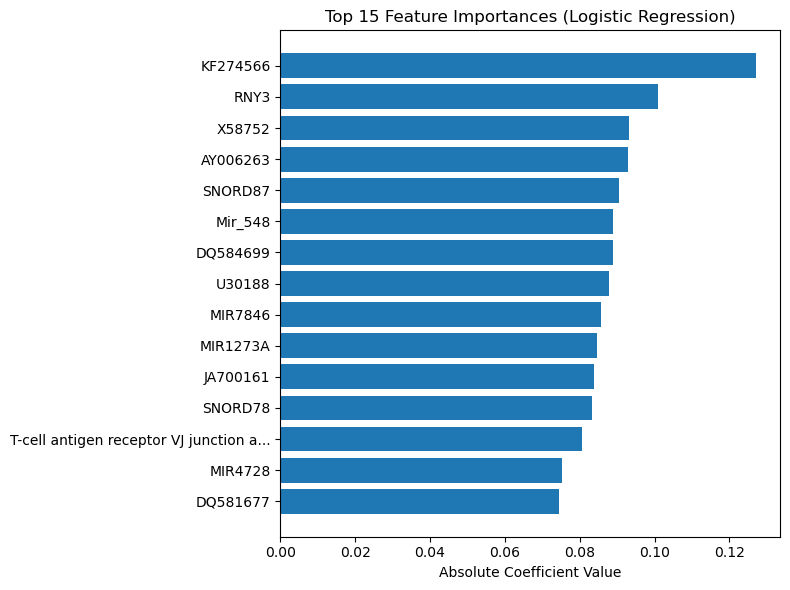

In [4]:
import matplotlib.pyplot as plt

feature_importance = np.abs(clf.coef_[0])
features = X.columns

# Get top 15 features
top_idx = np.argsort(feature_importance)[-15:]
top_features = features[top_idx]
top_importance = feature_importance[top_idx]

plt.figure(figsize=(8,6))
plt.barh(top_features, top_importance)
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


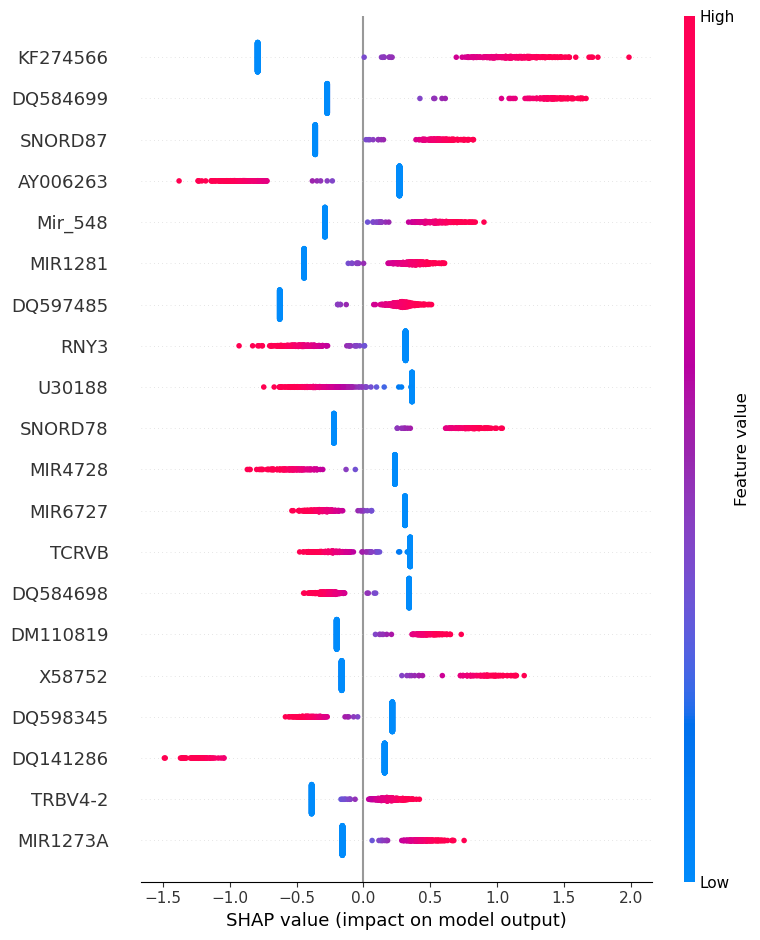

In [6]:
import matplotlib.pyplot as plt
import shap

# SHAP summary plot
explainer = shap.LinearExplainer(clf, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)# Feature importance (absolute value of coefficients)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define model and parameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "lbfgs"],
    "max_iter": [500, 1000]
}
model = LogisticRegression(class_weight="balanced")

# Grid search
grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.3f}")

# Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred, target_names=["ER negative", "ER positive"]))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))